In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from generation.data.data_simulation import Nakagami
from generation.data.dataset_pytorch import SignalsDataset
from generation.train.vanila_gan import run_train, generate_new_signal
from scipy import signal
from sklearn.linear_model import Ridge
import tqdm

In [2]:
# Data params
SAMPLE_SIZE = 50
Q_LOWER = 0.001
Q_UPPER = 0.999
NU_MIN = 0.9
NU_MAX = 1.2
NU_STEP = 0.0005

nakagami = Nakagami(SAMPLE_SIZE, Q_LOWER, Q_UPPER)
nu_values = np.arange(NU_MIN, NU_MAX, NU_STEP)
data = nakagami.get_nakagami_data(nu_values)

In [3]:
len(data)

600

In [24]:
### Parametrization params
LR_ALPHA= 0.1
GAUSSIAN_STD = 4
COMPRESS_COEF = 2

In [25]:
def get_gaussians(std, compress_coef):
    sample = data[np.random.choice(range(len(data)))]
    points_num = 2 * len(sample) + 1
    max_loc = np.argmax(signal.gaussian(points_num, std=std))
        
    gaussians = []
    for j in range(0, len(sample), compress_coef):
        start_pos = max_loc - j - 1
        end_pos = start_pos + len(sample)
        values = signal.gaussian(points_num, std=std)[start_pos:end_pos]
        gaussians.append(values)
    return gaussians

In [26]:
def transform_sample(sample, lr_alpha, std, compress_coef, to_visualize=False):
    def visualize():
        f, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].set_title("Gaussians")
        ax[1].set_title("Weighted gaussians")
        ax[2].set_title("Result")
        result = [lr.intercept_] * len(sample)
        for i, gaussian in enumerate(gaussians):
            ax[0].plot(gaussian)
            ax[1].plot(gaussian * lr.coef_[i])
            result += gaussian * lr.coef_[i]
        ax[2].plot(result)
        ax[2].plot(sample)
        ax[2].legend(['Gaussians sum', 'Origin signal'])
        plt.show()
    
    lr = Ridge(alpha=lr_alpha, fit_intercept=False)
    gaussians = get_gaussians(std, compress_coef)
    cur_X = np.array(gaussians).T
    cur_y = sample.copy()
    lr.fit(cur_X, cur_y)
    
    if to_visualize:
        visualize()
    
    return lr.coef_

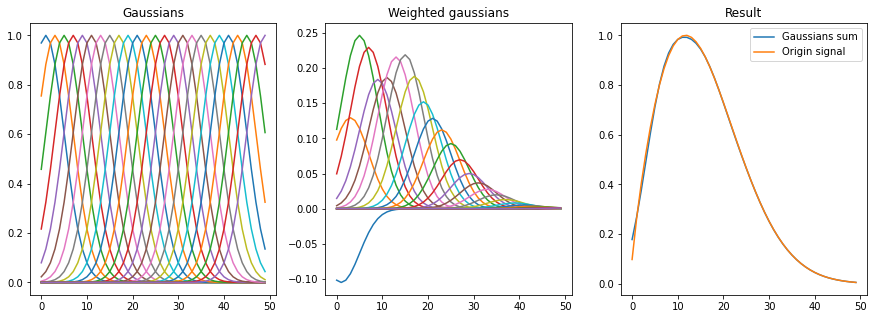

array([-0.10484807,  0.12932576,  0.2463821 ,  0.22930273,  0.18370763,
        0.18650741,  0.21557766,  0.21872236,  0.18815508,  0.15194225,
        0.12843729,  0.11212798,  0.09255306,  0.06968958,  0.05003538,
        0.03670131,  0.02751939,  0.0197162 ,  0.01294054,  0.0080606 ,
        0.00514856,  0.00340514,  0.00219416,  0.00139542,  0.00097783])

In [27]:
transform_sample(data[0], \
                 lr_alpha=LR_ALPHA, \
                 std=GAUSSIAN_STD, \
                 compress_coef=COMPRESS_COEF, \
                 to_visualize=True)

In [28]:
def transform_data(data, lr_alpha, std, compress_coef):
    new_data = []
    for sample in data:
        coef = transform_sample(sample, lr_alpha, std, compress_coef)
        new_data.append(coef)
    return new_data

In [29]:
new_data = transform_data(data, 
                          lr_alpha=LR_ALPHA,
                          std=GAUSSIAN_STD,
                          compress_coef=COMPRESS_COEF)

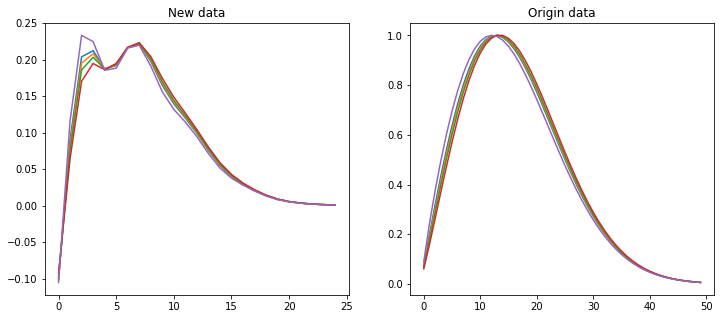

In [30]:
SAMPLES_NUM = 5

f, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("New data")
ax[1].set_title("Origin data")
for i in range(SAMPLES_NUM):
    idx = np.random.choice(range(len(new_data)))
    ax[0].plot(new_data[idx])
    ax[1].plot(data[idx])
plt.show()

In [31]:
### Training params
LATENT_DIM = 20
BATCH_SIZE = 128
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
PRINT_EACH = 200
VERBOSE = 1
NO_SAVE = True
DEVICE = 'cuda'


dataset = SignalsDataset(new_data)

epoch-0; D_loss: 1.2877731323242188; G_loss: 0.6654284000396729


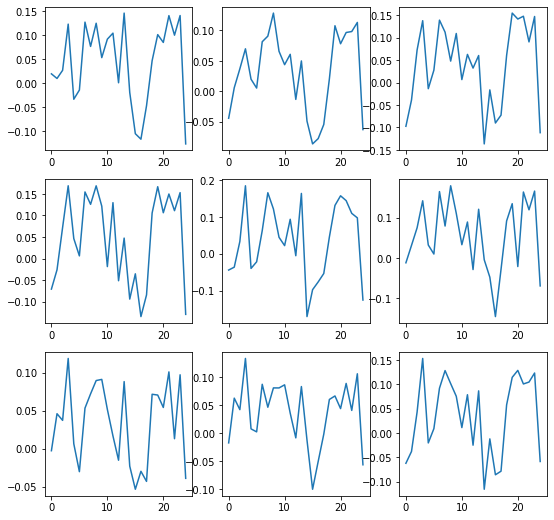

epoch-200; D_loss: 1.1785646677017212; G_loss: 0.7521041631698608


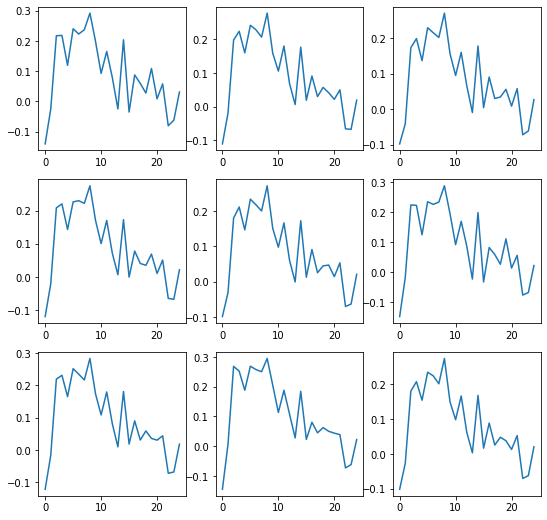

epoch-400; D_loss: 1.7932629585266113; G_loss: 0.5177720189094543


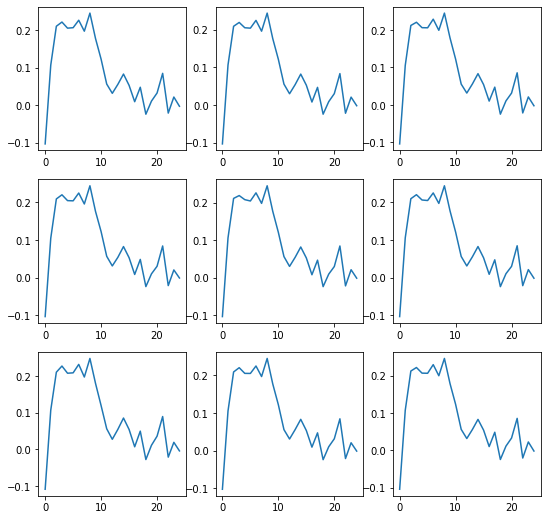

epoch-600; D_loss: 1.4677025079727173; G_loss: 0.6198346614837646


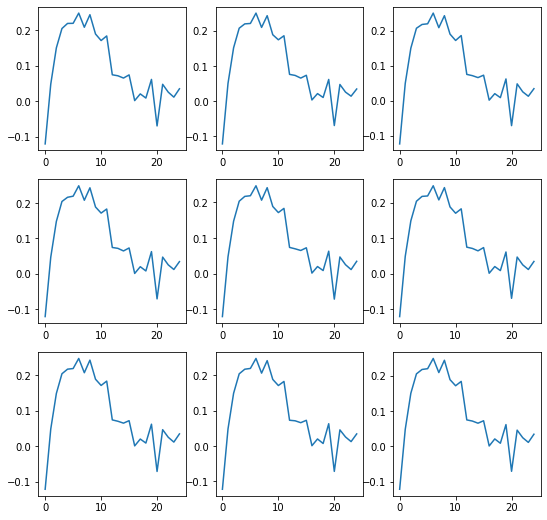

epoch-800; D_loss: 1.4173251390457153; G_loss: 0.7051815390586853


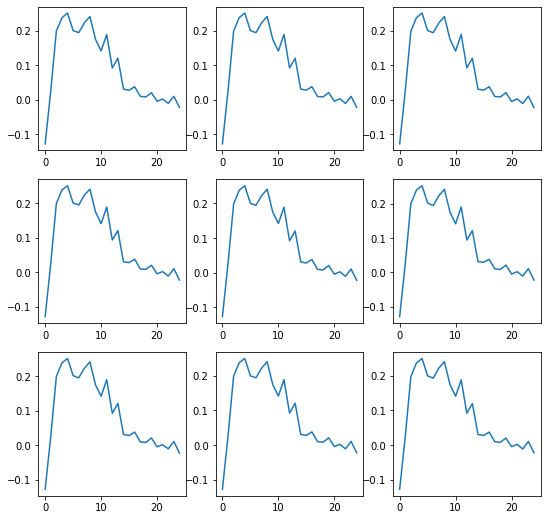

In [32]:
generator = run_train(dataset, \
          latent_dim=LATENT_DIM, \
          sample_size=len(new_data[0]), \
          learning_rate=LEARNING_RATE, \
          num_epochs=NUM_EPOCHS, \
          batch_size=BATCH_SIZE, \
          print_each=PRINT_EACH, \
          verbose=VERBOSE, \
          no_save=NO_SAVE, \
          device=DEVICE)

tensor([[-2.0200, -1.3793,  0.8047, -1.0681,  1.0521, -0.9653, -0.1084,  1.6279,
         -0.7590,  1.1283, -0.0669,  0.4731, -0.4662, -0.3528,  0.0702, -1.1121,
         -0.9369, -2.2237, -1.1534,  2.1399],
        [-0.6986, -0.0238, -0.7756,  0.2409, -0.2277,  0.8672, -2.1563,  0.1799,
          1.1202, -0.4521,  0.4893, -0.6638, -0.1771,  1.1653, -0.6355,  0.7875,
          0.9299,  0.4411, -2.0612,  0.0650]], device='cuda:0')


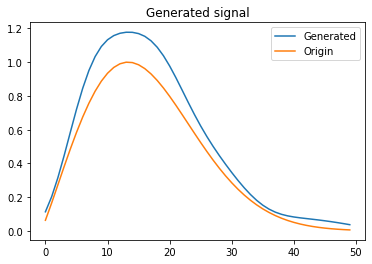

In [34]:
sample = generate_new_signal(generator, device='cuda')[0]
result = [0] * SAMPLE_SIZE
gaussians = get_gaussians(std=GAUSSIAN_STD, compress_coef=COMPRESS_COEF)
for j in range(len(gaussians)):
    result += sample[j] * gaussians[j]
plt.title("Generated signal")
plt.plot(result)
plt.plot(data[np.random.choice(range(len(data)))])
plt.legend(['Generated', 'Origin'])
plt.show()

In [35]:
for val in generator.model.parameters():
    print(val)

Parameter containing:
tensor([[-0.0297, -0.0090,  0.0593,  ..., -0.1748,  0.1372, -0.0697],
        [-0.0134,  0.0388,  0.0687,  ...,  0.1373,  0.1079, -0.0771],
        [-0.0800, -0.0363, -0.0718,  ..., -0.0027, -0.1479, -0.0966],
        ...,
        [ 0.1927, -0.0366,  0.1942,  ..., -0.1680, -0.1959, -0.0813],
        [-0.0495,  0.1002, -0.0701,  ..., -0.1495, -0.0787, -0.1300],
        [-0.1199,  0.1331,  0.1646,  ...,  0.0753, -0.0690,  0.0213]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0880, -0.3119, -0.2052, -0.0932, -0.2268, -0.0479, -0.0013, -0.3254,
        -0.0787, -0.1389, -0.1715, -0.2952, -0.0831,  0.0587, -0.1484,  0.0061,
        -0.1994,  0.0771,  0.0189,  0.1994, -0.1489,  0.0570, -0.1980,  0.0229,
        -0.0303, -0.2603, -0.2189, -0.2670, -0.2875, -0.0283, -0.2786,  0.0134,
        -0.3141, -0.0027, -0.1115, -0.1148,  0.1517, -0.2767, -0.1801, -0.2073,
         0.1514, -0.1972, -0.3504, -0.0577, -0.2933, -0.1647, -0.1481,  0.2021

Parameter containing:
tensor([[ 0.0190,  0.0164,  0.0513,  ...,  0.0082, -0.0187,  0.0189],
        [-0.0369, -0.0290, -0.0215,  ..., -0.0163, -0.0036,  0.0098],
        [ 0.0098,  0.0164, -0.0291,  ..., -0.0419, -0.0250,  0.0121],
        ...,
        [ 0.0562,  0.0245, -0.0228,  ...,  0.0453, -0.0154,  0.0188],
        [ 0.0343,  0.0499,  0.0099,  ...,  0.0641, -0.0584,  0.0215],
        [ 0.0005,  0.0484,  0.0093,  ...,  0.0120, -0.0274,  0.0319]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.0362, 0.0217, 0.0299,  ..., 0.0215, 0.0535, 0.0453], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([0.8692, 0.8759, 0.9062,  ..., 0.8254, 0.8791, 0.8842], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0114, -0.0101, -0.0151,  ..., -0.0085, -0.0203, -0.0126],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0065,  0.0218,  0.0103,  ...,  0.0109, -0.0288,  0.0091],
        [-0.000

In [36]:
generator(torch.randn(2, generator.latent_dim).cuda())

tensor([[-0.1311,  0.0721,  0.2105,  0.2987,  0.2542,  0.1902,  0.2237,  0.3059,
          0.1670,  0.3224,  0.1666,  0.1106,  0.1199,  0.0882,  0.1031,  0.0427,
          0.0377,  0.0110,  0.0115,  0.0217,  0.0051,  0.0398, -0.0192,  0.0300,
          0.0070],
        [-0.1303,  0.0691,  0.2101,  0.2981,  0.2533,  0.1907,  0.2218,  0.3051,
          0.1666,  0.3224,  0.1677,  0.1093,  0.1196,  0.0887,  0.1030,  0.0412,
          0.0381,  0.0121,  0.0096,  0.0198,  0.0045,  0.0412, -0.0189,  0.0303,
          0.0066]], device='cuda:0', grad_fn=<TanhBackward>)

tensor([[ 0.7054,  0.8220,  1.2842, -0.9361, -0.6193, -0.7795,  2.4620,  0.1335,
          0.6111, -0.1480, -0.8163, -0.5189, -0.4714, -1.8658, -1.3211, -0.6039,
          0.7142,  1.3421,  2.0890,  1.7634],
        [ 1.3954, -0.9292,  0.2356, -0.7728,  1.1310, -0.1128,  0.4908, -0.7596,
          0.3270, -0.4131,  0.2589, -0.5737, -1.7800, -0.0912,  1.0848, -0.9104,
          0.3211, -1.0469, -0.2298,  1.3331],
        [ 0.9762,  0.4141, -0.3514, -0.1518,  0.7332,  1.2758, -0.2041,  0.3701,
         -1.8269,  0.1220, -0.3648, -1.2841, -1.4462, -0.1234,  1.4407,  0.2253,
          0.7801, -0.7316,  0.6069, -0.3560],
        [-1.6472,  0.8169,  1.0658,  1.9119,  0.0773, -0.2428, -0.5434,  1.8520,
          1.6417, -0.4183, -0.0144,  1.2319, -0.9542, -0.4378,  0.8162,  0.9090,
         -0.5945,  0.5690, -0.0778, -0.5886],
        [ 0.4189,  0.6605,  1.0788, -0.9935,  0.1595,  0.1988, -0.0186, -0.0974,
          0.6780, -0.3196, -1.4345,  1.4000,  0.1465, -2.3560,  0.3763,  0.3249,
      

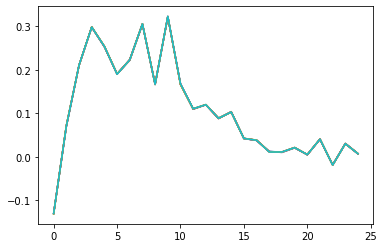

In [37]:
samples = generate_new_signal(generator, device='cuda', signals_num=10)
for sample in samples:
    plt.plot(sample)
plt.show()